In [4]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from os import listdir
import json
import seaborn as sns

In [5]:
import cufflinks as cf
cf.go_offline()

# Iterative 52 weeks Forecasting

- $mu*kernel1 + lmbda*kernel2$

- $mu, lmbda > 0$

## Get all pickle files

- One file for each set of hyperparameters

In [6]:
# list of Pickle files names
path = Path().resolve().parent / 'Pickles'/ 'K_75_52_mu_lambda'
list_dir = listdir(path)
files = [ld for ld in list_dir if ld[-2:-1].isdigit()]

In [36]:
# Open Pickles wich contain a dir of dirs 
# dir_parent: contain all runs dictionary. Labeled by date and time
# dir_son: contain a dictionary of one run. labeled by week (1 - 52). 0 contain hyperparameter information.
def open_pickle(path, files):
    tame = {}
    for ld in files:
        with open(f"{path}\\{ld}", 'rb') as f:
            tame[ld] = pickle.load(f)
    return tame

In [8]:
pkls = open_pickle(path, files)

In [9]:
pkls.keys() # dict keys/File names

dict_keys(['07_04_2021_13_19_55', '07_04_2021_14_00_17', '07_04_2021_14_46_22', '07_04_2021_15_32_29', '07_04_2021_17_41_13', '07_04_2021_20_09_58', '07_04_2021_20_53_48', '07_04_2021_21_36_23', '07_04_2021_22_18_48', '08_04_2021_00_17_27', '08_04_2021_00_57_47', '08_04_2021_01_43_47', '08_04_2021_08_35_16', '08_04_2021_09_20_25', '08_04_2021_10_11_48'])

In [10]:
pkls['07_04_2021_13_19_55'][0]

{'kernel': 'rbf',
 'C': 4.228517846555483,
 'epsilon': 7.20604168948716,
 'mu': 0.7423118951773942,
 'lmbda': 1.5186395374328805,
 'gamma': 0.00011142604425275418}

In [11]:
# Dataset's last week [1] prediction for hyperparameters on [0]
ma = pkls['07_04_2021_13_19_55'][1].error.mean()*100
pkls['07_04_2021_13_19_55'][1][["real", "predict"]].iplot(title = f"MAPE: {ma:.2f}")

## Joins weeks on each file

In [12]:
# Join each dir_son sequentially by date. Dir labeled by date.
# recives dir of dirs. Returns dir of ordered 52 weeks prediction
def join_pickle(pkls):
    li_n = {}
    for a in pkls.keys():
        li_n[a] = pd.DataFrame()
        for i in range(1, 53):
            li_n[a] = pd.concat([li_n[a], pkls[a][i]], axis = 0)
        li_n[a] = li_n[a].sort_index()
    return li_n

In [13]:
jointed = join_pickle(pkls)

In [14]:
# hyperparameters values for file
pkls['07_04_2021_13_19_55'][0]

{'kernel': 'rbf',
 'C': 4.228517846555483,
 'epsilon': 7.20604168948716,
 'mu': 0.7423118951773942,
 'lmbda': 1.5186395374328805,
 'gamma': 0.00011142604425275418}

In [15]:
# Plot specific file real and prediction
mape = jointed['07_04_2021_13_19_55'].error.mean()*100
jointed['07_04_2021_13_19_55'][["real", "predict"]].iplot(title = f"MAPE: {mape:.2f}")

## Plot specific predictions vs real

In [16]:
# concatenate real value and prediction for all runs.
# argument: dir of jointed dataframes. returns real values and all predictions 
def concat_pred(j_p):
    pred_tot = pd.DataFrame()
    pred_tot["real"] = j_p[[*j_p.keys()][0]]['real']
    name = ['real']
    for a in j_p.keys():
        pred_tot = pd.concat([pred_tot, j_p[a]['predict']], axis = 1)
        name.append(a)
    pred_tot.columns = name
    return pred_tot

In [17]:
lok = concat_pred(jointed)

In [18]:
lok.iplot() # double click on name to plot single plots

## Plot specific error

In [19]:
# concatenate real value and prediction for all runs.
# argument: dir of jointed dataframes. 
# return: error given by abs((y - pred)/y)
def concat_error(j_p):
    error_tot = pd.DataFrame()
    for a in j_p.keys():
        error_tot = pd.concat([error_tot, j_p[a]['error']], axis = 1)
    error_tot.columns = [*j_p.keys()]
    return error_tot

In [20]:
error_tot = concat_error(jointed)

In [21]:
error_tot.mean()*100

07_04_2021_13_19_55     2.570842
07_04_2021_14_00_17     2.694270
07_04_2021_14_46_22     2.952639
07_04_2021_15_32_29     9.842445
07_04_2021_17_41_13     2.505389
07_04_2021_20_09_58    84.778880
07_04_2021_20_53_48     3.928083
07_04_2021_21_36_23     2.612366
07_04_2021_22_18_48     2.541685
08_04_2021_00_17_27     2.570843
08_04_2021_00_57_47     2.693418
08_04_2021_01_43_47     2.953764
08_04_2021_08_35_16     9.819757
08_04_2021_09_20_25    31.480736
08_04_2021_10_11_48     7.896598
dtype: float64

In [22]:
error_tot.iplot()

# Target against parameters mu & lambda

## Load data 

In [58]:
path_json = path.parents[1] / 'Logs' / 'log_52weeks_mulambda.json'

In [59]:
# read data in json file containing target and hyperparameters
data = []
for line in open(path_json, 'r'):
    data.append(json.loads(line))

In [60]:
# creates dataframe with scaled target (for corrections)
def create_dataframe_scaled(data, scale):
    itera = range(len(data))
    #hyperparameters
    hyper = [[*data[i]['params'].values()] for i in itera]
    df = pd.DataFrame(hyper, columns = [*data[0]['params'].keys()])
    # target
    df["target"] = [-data[i]['target']*scale for i in itera]
    # datetime
    df["datetime"] = [data[i]['datetime']['datetime'] for i in itera]
    return df

In [ ]:
df = create_dataframe_scaled(data = data, scale = 53/52)

## Plot

In [62]:
df.columns

Index(['C', 'epsilon', 'gamma', 'lmbda', 'mu', 'target', 'datetime'], dtype='object')

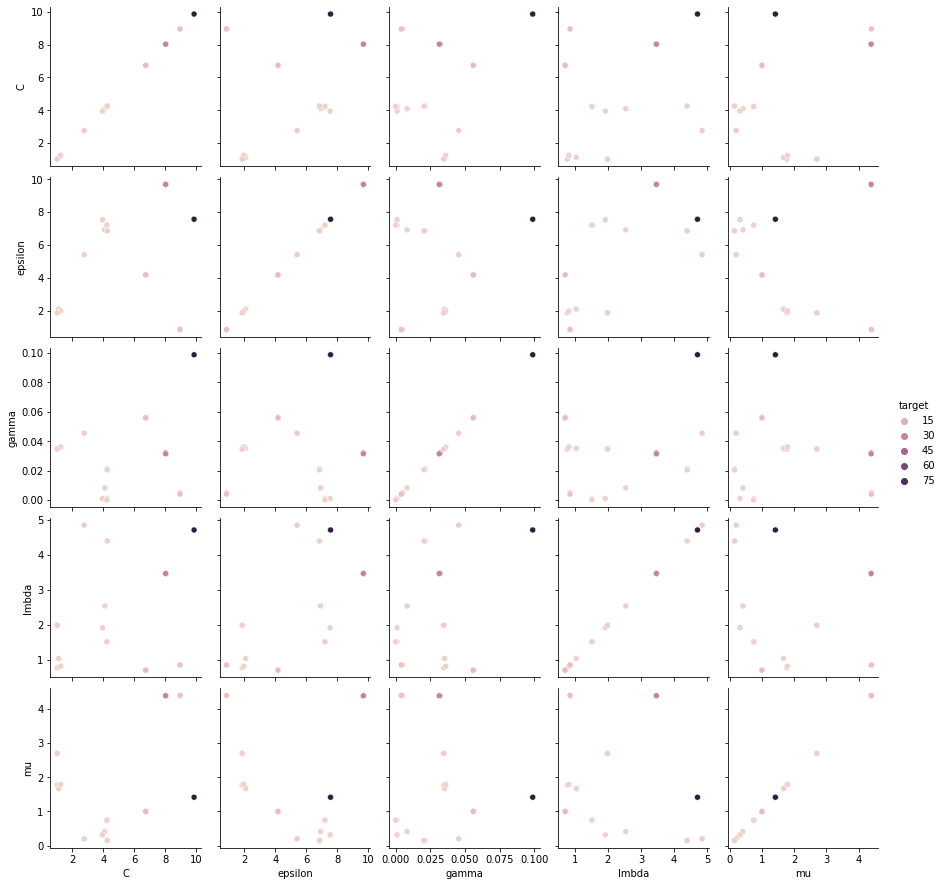

In [77]:
sns.pairplot(data = df, hue = "target", kind = "scatter", diag_kind = None);

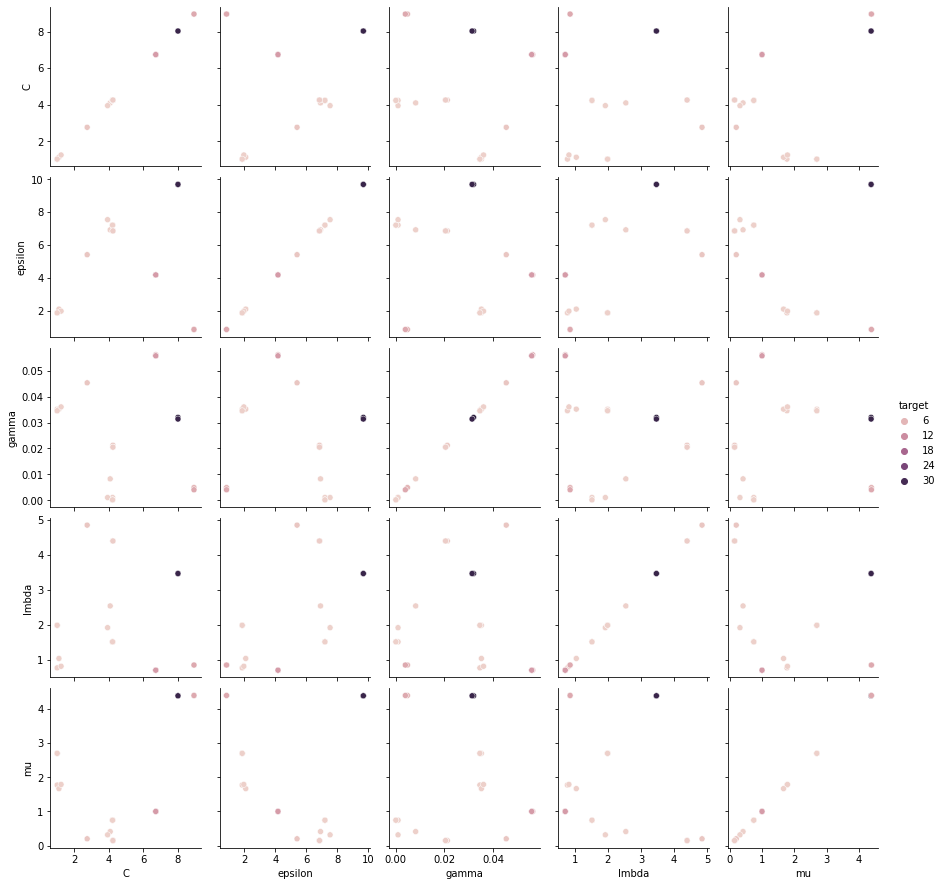

In [135]:
sns.pairplot(data = df.drop(13), hue = "target", kind = "scatter", diag_kind = None);

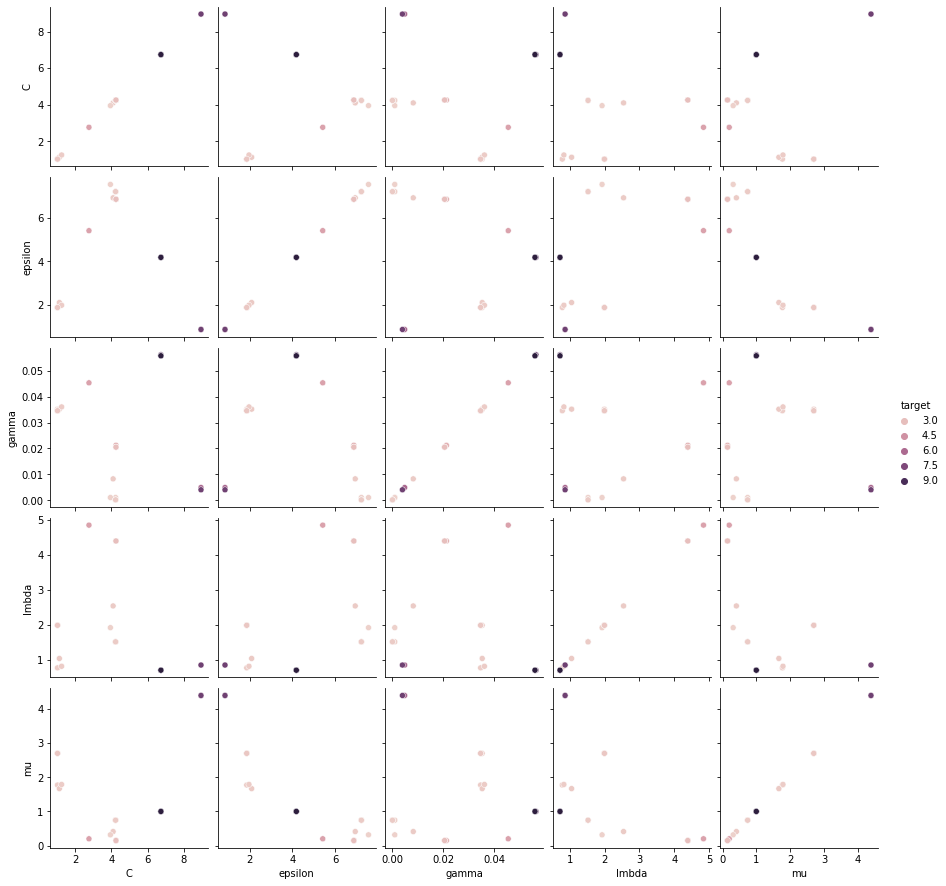

In [136]:
sns.pairplot(data = df.drop([4, 13, 21]), hue = "target", kind = "scatter", diag_kind = None);

In [88]:
import plotly.express as px

In [129]:
px.scatter_matrix(df.drop(["datetime"], axis = 1), color="target")

<AxesSubplot:xlabel='C', ylabel='gamma'>

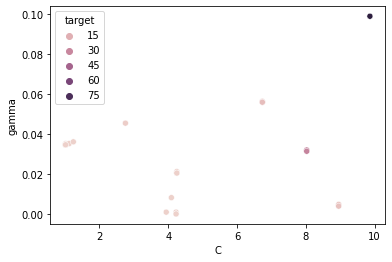

In [113]:
sns.scatterplot(x = df.C, y = df.gamma, hue = df.target)

# Iterative 52 weeks Forecasting

- $mu*f1 + (1-mu)*f2$

- $|mu| < 2$

## functions

In [ ]:
def open_pickle(path, files):
    tame = {}
    for ld in files:
        with open(f"{path}\\{ld}", 'rb') as f:
            tame[ld] = pickle.load(f)
    return tame

def concat_pred(j_p):
    pred_tot = pd.DataFrame()
    pred_tot["real"] = j_p[[*j_p.keys()][0]]['real']
    name = ['real']
    for a in j_p.keys():
        pred_tot = pd.concat([pred_tot, j_p[a]['predict']], axis = 1)
        name.append(a)
    pred_tot.columns = name
    return pred_tot

def concat_pred(j_p):
    pred_tot = pd.DataFrame()
    pred_tot["real"] = j_p[[*j_p.keys()][0]]['real']
    name = ['real']
    for a in j_p.keys():
        pred_tot = pd.concat([pred_tot, j_p[a]['predict']], axis = 1)
        name.append(a)
    pred_tot.columns = name
    return pred_tot

def concat_error(j_p):
    error_tot = pd.DataFrame()
    for a in j_p.keys():
        error_tot = pd.concat([error_tot, j_p[a]['error']], axis = 1)
    error_tot.columns = [*j_p.keys()]
    return error_tot

## Get all pickle files

- One file for each set of hyperparameters

In [43]:
# list of Pickle files names
path_mu = Path().resolve().parent / 'Pickles'/ 'K_7_52_nw'
list_dir_mu = listdir(path_mu)
files_mu = [ld for ld in list_dir_mu if ld[-2:-1].isdigit()]

In [45]:
# Open Pickles wich contain a dir of dirs 
# dir_parent: contain all runs dictionary. Labeled by date and time
# dir_son: contain a dictionary of one run. labeled by week (1 - 52). 0 contain hyperparameter information.
pkls_mu = open_pickle(path_mu, files_mu)

In [46]:
pkls_mu.keys() # dict keys/File names

dict_keys(['08_04_2021_23_56_19', '09_04_2021_01_37_33', '09_04_2021_03_06_44', '09_04_2021_04_42_38', '09_04_2021_06_15_21', '09_04_2021_07_53_06', '09_04_2021_09_36_56', '09_04_2021_11_16_48', '09_04_2021_13_04_58', '09_04_2021_14_52_30', '09_04_2021_16_39_09', '09_04_2021_18_30_47'])

In [47]:
pkls_mu['08_04_2021_23_56_19'][0]

{'kernel': 'rbf', 'C': 0.5, 'epsilon': 0.01, 'mu': -0.3, 'gamma': 0.02}

In [48]:
# Dataset's last week [1] prediction for hyperparameters on [0]
ma = pkls_mu['08_04_2021_23_56_19'][1].error.mean()*100
pkls_mu['08_04_2021_23_56_19'][1][["real", "predict"]].iplot(title = f"MAPE: {ma:.2f}")

## Joins weeks on each file

In [49]:
# Join each dir_son sequentially by date. Dir labeled by date.
# recives dir of dirs. Returns dir of ordered 52 weeks prediction
jointed_mu = join_pickle(pkls_mu)

In [50]:
# hyperparameters values for file
pkls_mu['08_04_2021_23_56_19'][0]

{'kernel': 'rbf', 'C': 0.5, 'epsilon': 0.01, 'mu': -0.3, 'gamma': 0.02}

In [51]:
# Plot specific file real and prediction
mape_mu = jointed_mu['08_04_2021_23_56_19'].error.mean()*100
jointed_mu['08_04_2021_23_56_19'][["real", "predict"]].iplot(title = f"MAPE: {mape_mu:.2f}")

## Plot specific predictions vs real

In [52]:
# concatenate real value and prediction for all runs.
# argument: dir of jointed dataframes. returns real values and all predictions 
lok_mu = concat_pred(jointed_mu)

In [53]:
lok_mu.iplot() # double click on name to plot single plots

## Plot specific error

In [54]:
# concatenate real value and prediction for all runs.
# argument: dir of jointed dataframes. 
# return: error given by abs((y - pred)/y)
error_totmu = concat_error(jointed_mu)

In [55]:
error_totmu.mean()*100

08_04_2021_23_56_19    2.508360
09_04_2021_01_37_33    2.817411
09_04_2021_03_06_44    3.147880
09_04_2021_04_42_38    2.336533
09_04_2021_06_15_21    2.642908
09_04_2021_07_53_06    4.692162
09_04_2021_09_36_56    2.298305
09_04_2021_11_16_48    3.152091
09_04_2021_13_04_58    2.941403
09_04_2021_14_52_30    2.401318
09_04_2021_16_39_09    3.802310
09_04_2021_18_30_47    2.334306
dtype: float64

In [56]:
error_totmu.iplot()

#  Target against paramter new mu

In [1]:
import plotly.express as px

In [21]:
def create_dataframe_scaled(data, scale):
    itera = range(len(data))
    #hyperparameters
    hyper = [[*data[i]['params'].values()] for i in itera]
    df = pd.DataFrame(hyper, columns = [*data[0]['params'].keys()])
    # target
    df["target"] = [-data[i]['target']*scale for i in itera]
    # datetime
    df["datetime"] = [data[i]['datetime']['datetime'] for i in itera]
    return df

In [22]:
path_json_mu = Path().resolve().parent / 'Logs' / 'log_new_w.json'

In [23]:
# read data in json file containing target and hyperparameters
data_mu = []
for line in open(path_json_mu, 'r'):
    data_mu.append(json.loads(line))

In [24]:
# creates dataframe with scaled target (for corrections)
df_mu = create_dataframe_scaled(data = data_mu, scale = 1)

## Plot

In [25]:
df_mu.columns

Index(['C', 'epsilon', 'gamma', 'mu', 'target', 'datetime'], dtype='object')

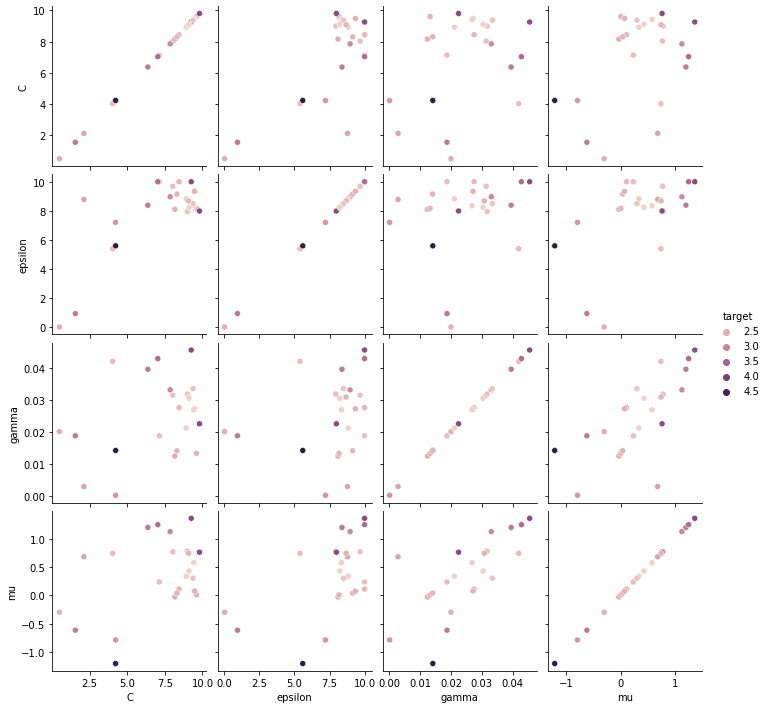

In [11]:
sns.pairplot(data = df_mu, hue = "target", kind = "scatter", diag_kind = None);

In [27]:
px.scatter_matrix(df_mu.drop(["datetime"], axis = 1), color="target")

In [26]:
df_mu

,C,epsilon,gamma,mu,target,datetime
0,0.500000,0.010000,0.020000,-0.300000,2.508360,2021-04-08 23:56:19
1,4.228518,7.206042,0.000111,-0.790670,2.817411,2021-04-09 01:37:33
2,1.552883,0.932463,0.018707,-0.617757,3.147880,2021-04-09 03:06:44
3,4.027998,5.392779,0.041978,0.740878,2.336533,2021-04-09 04:42:38
4,2.124077,8.782393,0.002836,0.681870,2.642908,2021-04-09 06:15:21
5,4.231318,5.591311,0.014125,-1.207594,4.692162,2021-04-09 07:53:06
6,8.027371,9.682933,0.031411,0.769290,2.298305,2021-04-09 09:36:56
7,6.371985,8.387577,0.039524,1.200071,3.152091,2021-04-09 11:16:48
8,7.853525,8.965868,0.033078,1.126920,2.941403,2021-04-09 13:04:58
9,8.439596,10.000000,0.027513,0.110273,2.401318,2021-04-09 14:52:30


<AxesSubplot:xlabel='C', ylabel='epsilon'>

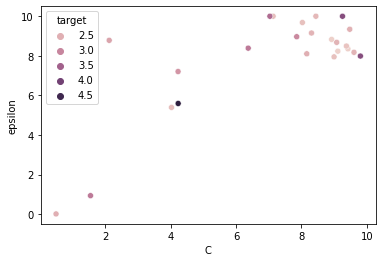

In [20]:
sns.scatterplot(x = df_mu.C, y = df_mu.epsilon, hue = df_mu.target)